# Introduction

This data set was collected by Gerhard van de Bunt, and is discussed extensively in van de Bunt (1999) and van de Bunt, van Duijn, and Snijders (1999). The data were collected among a group of university freshmen at 7 time points. The first four time points are three weeks apart, whereas the last three time points are six weeks apart. The original group consisted of 49 students, but due to 'university drop-outs' and after deleting those who did not fill in the questionnaire four or more times, a group was obtained of 32 students for whom almost complete data are available.

The students were asked to rate their relationships on a six point scale, with response categories described as follows.

1 = *Best friendship* Persons whom you would call your 'real' friends

2 = Friendship Persons with whom you have a good relationship, but whom you do not (yet) consider a 'real' friend

3 = Friendly relationship Persons with whom you regularly have pleasant contact during classes. The contact could grow into a friendship

4 =  Neutral relationship Persons with whom you have not much in common. In case of an accidental meeting the contact is good. The chance of it growing into a friendship is not large

0 = Unknown person Persons whom you do not know

5 = Troubled relationship Persons with whom you can't get on very well, and with whom you definitely do not want to start a relationship. There is a certain risk of getting into a conflict

In [135]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import community
import itertools as it

In [2]:
df = pd.read_excel('/Users/cdalyac/Desktop/Datavdb.xlsx',index_col=[0])
df

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,4,0,0,3,0,3,0,0,0,4,...,0,4,0,4,2,0,2,3,0,4
221,4,4,4,3,4,1,4,4,0,4,...,4,3,4,4,1,1,0,1,4,4
222,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,0,9,9
223,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0,9


In [3]:
matrix = df.as_matrix()
np.count_nonzero(matrix)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


3821

## Data cleaning 

The networks are coded as 6 = item non-response, 9 = actor non-response. We therefore give 0 to non-responses because it's unexploitable.

In [4]:
for i in range (len(matrix)):
    for j in range (len(matrix[i])):
        if matrix[i][j] == 6 or matrix[i][j] == 9 :
            matrix[i][j] = 0

Seperating the different timesteps: 

In [5]:
def matrix_to_submatrices(matrix,N,M,i,j): #ixj is the dimension of the submatrices.
    subA = []
    k1 = N // i 
    k2 = M // j
    B = np.array_split(matrix,k1,axis=0)
    for i in range(len(B)):
        subA_i = np.array_split(B[i],k2, axis=1)
        for j in range(len(subA_i)):
            subA.append(np.asarray(subA_i[j]))
    return subA
N = len(matrix) #lignes
M = len(matrix[0]) #colonnes
i = j = 32
time_step_matrices = matrix_to_submatrices(matrix,N,M,i,j)


In [6]:
print(len(time_step_matrices))

7


We convert the different timesteps to csv files in order to plot the graphs in Gephi. 

In [ ]:
for i in range(len(time_step_matrices)):
    pd.DataFrame(time_step_matrices[i]).to_csv('/Users/cdalyac/Desktop/Datavdb_clean' + str(i) + '.csv', header=None,index=None)   

 convert them to Gephi to see the dynamics 

In [61]:
def labels_and_times(time_step_matrices):
    A = []
    labels = [i for i in range(1,6)]
    for i in labels:
        for j in range(len(time_step_matrices)):
            M = time_step_matrices[j].copy()
            for k in range (len(M)):
                for l in range (len(M)):
                    if M[k][l] != i :
                        M[k][l] = 0
            pd.DataFrame(M).to_excel('/Users/cdalyac/Desktop/Datavdb_label=' + str(i) + '_timestep_'+ str(j) + '.xlsx')
            A.append(M)
    return A

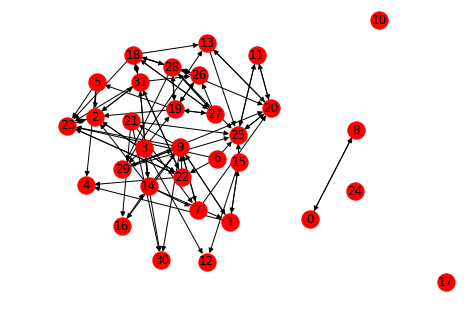

In [62]:
B = labels_and_times(time_step_matrices)
testt_G = nx.from_numpy_matrix(B[15],create_using=nx.DiGraph())
nx.draw(testt_G,with_labels= True, pos=graphviz_layout(G))

0
0
3
6
9
19
14
0
19
45
49
53
68
42
6
91
82
91
113
143
112
3
284
390
319
311
395
338
1
11
10
15
12
5
3


# For timestep = 1 

Below, we convert the adjacency list to a graph where each edge has an attribute 'weight'

In [140]:
G = nx.from_numpy_matrix(time_step_matrices[1],create_using=nx.DiGraph())

We then add several features to each nodes. The actor attributes are in the file vdbatt.dat. Variables are, respectively, gender (1 = F, 2 = M), program (2-year, 3-year, 4-year), and smoking (1 = yes, 2 = no). 

In [11]:
nodes_features = pd.read_excel('/Users/cdalyac/Desktop/data_gender.xlsx')

In [169]:
for i in sorted(G.nodes()):
    G.node[i]['Course'] = nodes_features.Course[i]
    G.node[i]['Gender'] = nodes_features.Gender[i]
    G.node[i]['Smoking'] = nodes_features.Smoking[i]
    
G.nodes[2]
for n in G.nodes():
    print(G.nodes[n]['Gender'])

1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
2
1
2
1
1
1
1
2
2
2
2
1
1
1


In [13]:
non_isolated_nodes = [i for i in range(32)]
np.delete(non_isolated_nodes, [10,17])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [14]:
non_isolated_nodes = [i for i in range(32)]
connected_nodes = list(np.delete(non_isolated_nodes, [10,17]))
SubG = G.subgraph(connected_nodes)
SubG.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31))

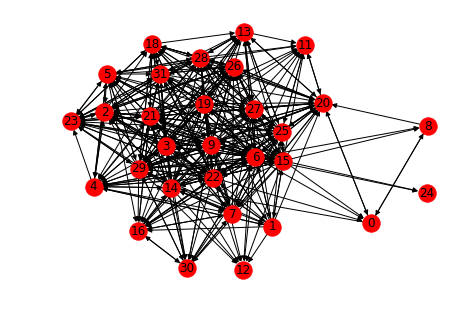

In [16]:
nx.draw(SubG,with_labels= True, pos=graphviz_layout(G))

## Detecting communities

In [ ]:
communities_generator = community.girvan_newman(SubG)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
list(sorted(next_level_communities))

Because most students rate the whole class, the graph is quite dense and measuring communities with degree information makes no sense

### Who are friends? 

Let's plot the graph of friendship, i.e. just with label = 1

In [182]:
friends_1=[]
for edge in G.edges():
    a,b = edge[0], edge[1]
    if G[a][b]['weight'] == 1:
        friends.append(edge)
friends_1
    

[]

Okay, no one came with a good friend to university! 

91

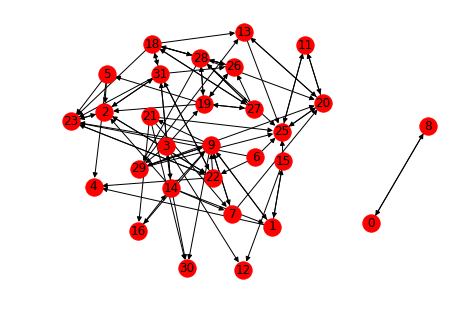

In [30]:
friends_3=[]
for edge in G.edges():
    a,b = edge[0], edge[1]
    if G[a][b]['weight'] == 3:
        friends_3.append(edge)
subG_t1_3 = G.edge_subgraph(friends_3)

nx.draw(subG_t1_3,with_labels= True, pos=graphviz_layout(G))
subG_t1_3.number_of_edges()

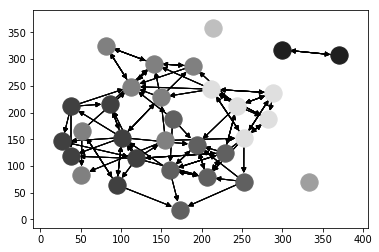

In [87]:
B = labels_and_times(time_step_matrices)
testt_G = nx.from_numpy_matrix(B[15],create_using=nx.DiGraph())
# nx.draw(testt_G,with_labels= True, pos=graphviz_layout(G))
partition = community.best_partition(testt_G.to_undirected())
#drawing
size = float(len(set(partition.values())))
pos = graphviz_layout(testt_G)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(testt_G, pos,list_nodes, node_color = str(count / size))
    nx.draw_networkx_edges(testt_G, pos, alpha=0.5)
plt.show()

In [80]:
partition

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 2,
 5: 2,
 6: 2,
 7: 1,
 8: 0,
 9: 1,
 10: 4,
 11: 3,
 12: 3,
 13: 3,
 14: 1,
 15: 3,
 16: 1,
 17: 5,
 18: 6,
 19: 6,
 20: 3,
 21: 1,
 22: 2,
 23: 2,
 24: 7,
 25: 3,
 26: 6,
 27: 6,
 28: 6,
 29: 3,
 30: 1,
 31: 2}

In [72]:
def time_evolution(label):
    for i in range(7):
        test = pd.read_excel('/Users/cdalyac/Desktop/timesteps_data_EXCEL/Datavdb_label='+str(label)+'_timestep_'+str(i)+'.xlsx',index_col=[0])
        Xmatrix = test.as_matrix()
        X_G = nx.from_numpy_matrix(Xmatrix,create_using=nx.DiGraph())
        plt.figure(i)
        nx.draw(X_G,with_labels= True, pos=graphviz_layout(G))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


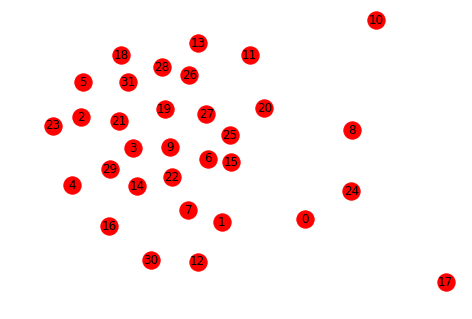

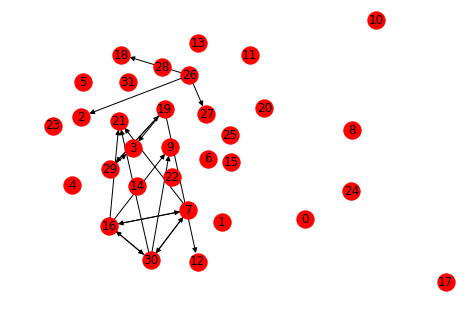

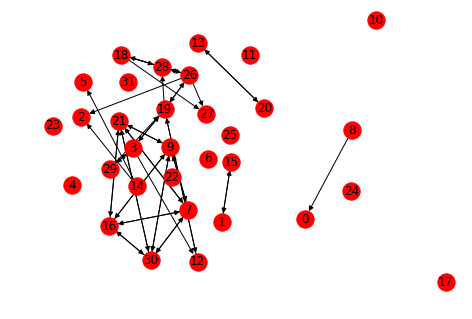

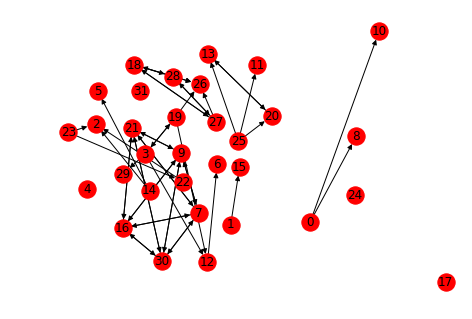

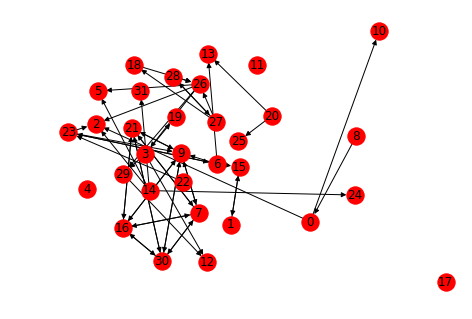

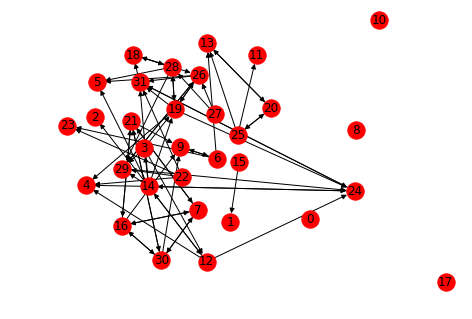

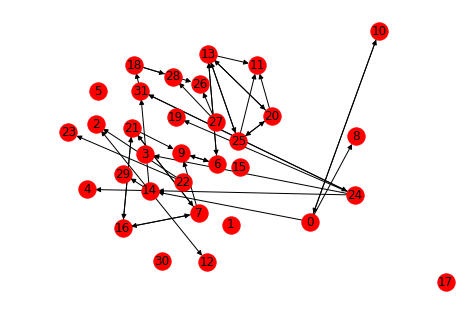

In [74]:
time_evolution(2)

# Community detection

In [154]:
def community_label(label):
    timestep_partition =[] 
    for i in range(7):
        test = pd.read_excel('/Users/cdalyac/Desktop/timesteps_data_EXCEL/Datavdb_label='+str(label)+'_timestep_'+str(i)+'.xlsx',index_col=[0])
        Xmatrix = test.as_matrix()
        X_G = nx.from_numpy_matrix(Xmatrix,create_using=nx.DiGraph())
        partition = community.best_partition(X_G.to_undirected())
        timestep_partition.append(partition)
        #drawing
        size = float(len(set(partition.values())))
        pos = graphviz_layout(X_G)
        count = 0.
        for com in set(partition.values()) :
            count += 1.
            list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
            nx.draw_networkx_nodes(X_G,pos,list_nodes, node_color = str(count / size))
            nx.draw_networkx_edges(X_G, pos, alpha=0.5)
        plt.show()
    return timestep_partition        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


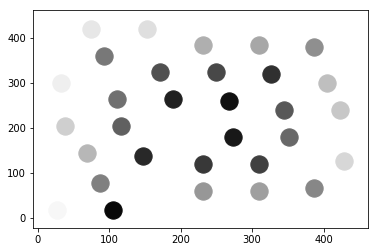

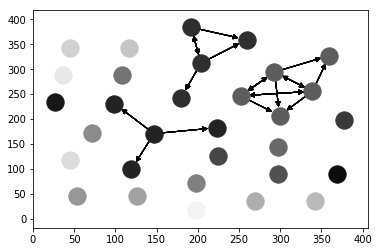

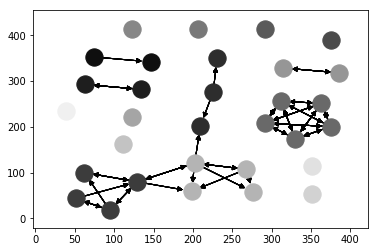

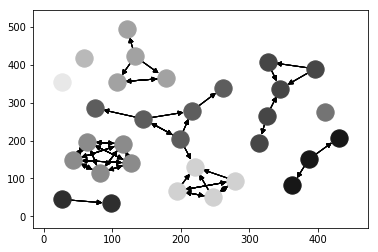

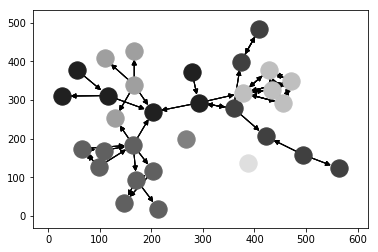

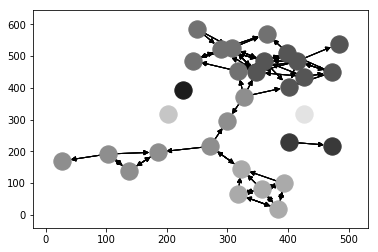

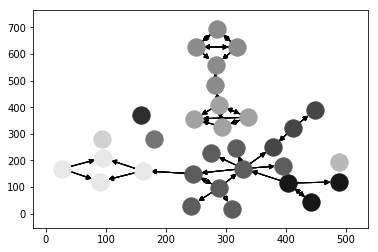

In [153]:
community_2 = community_label(2)

In [151]:
def connected_components(community):#community est une liste de partitions 
    con_components = []
    for i in range(7):
        d = community[i]
        communities = {','.join(str(k) for k in d.keys() if d[k] == v): v for v in set(d.values())} #keys are the connected components
        con_components.append(communities.keys())
    return con_components

In [152]:
connected_components(community_2)

[dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']),
 dict_keys(['0', '1', '2,18,26,27', '3,12,19,29', '4', '5', '6', '7,9,16,21,30', '8', '10', '11', '13', '14', '15', '17', '20', '22', '23', '24', '25', '28', '31']),
 dict_keys(['0,8', '1,15', '2,5,14', '3,12,19,29', '4', '6', '7,9,16,21,30', '10', '11', '13,20', '17', '18,26,27,28', '22', '23', '24', '25', '31']),
 dict_keys(['0,8,10', '1,15', '2,5,14,22,23', '3,6,12,19,29', '4', '7,9,16,21,30', '11,13,20,25', '17', '18,26,27,28', '24', '31']),
 dict_keys(['0,2,8,10,22,23', '1,6,13,15,20,25', '3,12,18,19,26,27,28,29', '4', '5,14,24,31', '7,9,16,21,30', '11', '17']),
 dict_keys(['0', '1,15', '2,3,4,12,14,19,24,29', '5,18,26,27,28,31', '6,11,13,20,22,23,25', '7,9,16,21,30', '8', '10', '17']),
 dict_keys(['0,8,10', '1', '2,22,23', '3,4,12,14,19,24,29,31', '5', '6,7,9,16,21', '11,13,20,25', '15',

We see that community detection in time is a hard task, as estimating communities snapshot by snapshot gives weird results. 
For example, 0 and 8 become friends, then the size of their friends group increases, but suddenly they all split, 22 and 23 joining another group. Is it because of a real conflict that took place, or is it a problem of community detection? We are eager to believe that friendship over a year is more robust that the Louvain algorithm of seperated snapshots.

## Correlation between features and communities 

In [178]:
def color(G,color='gender'): #G must have the features included! 
    if color == 'Gender':
        colors_gender = []
        for n in G.nodes(data=True):
            if 1 in G.nodes[n]['Gender']:
                colors_gender.append('pink')
            else:
                colors_gender.append('blue')
        return colors_gender
    elif color == 'Smoking':
        colors_smoker = []
        for n in G.nodes(data=True):
            if G.nodes[n]['Smoking'] == 1:
                node_color.append('green')
            else: colors_smoker.append('yellow')
        return colors_smoker

    elif color == 'Course':
        colors_course = []
        for node in G.nodes(data=True):
            if G.nodes[n]['Course'] == 2:
                node_color.append('blue')
            elif G.nodes[n]['Course'] == 3:
                node_color.append('yellow')
            else: node_color.append('red')
        return colors_course



In [179]:
color(G,color='Gender')

TypeError: unhashable type: 'dict'

## Centralities

# Brouillon 

In [ ]:
friends_5=[]
for edge in G.edges():
    a,b = edge[0], edge[1]
    if G[a][b]['weight'] == 5:
        friends_5.append(edge)
subG_t1_5 = G.edge_subgraph(friends_5)
nx.draw(subG_t1_5,with_labels= True, pos=graphviz_layout(G))